The goal of this project is to be able to classify users in the psychictxt application based on their usage. The data if from Sept 1 2015 - October 10 2015. The labels we are
going to user are:

Whale: For users who have asked and paid for more than 6 questions
High Roller: For users who have asked between 2-5 questions
Player: For users who have only asked 2 questions
Lapse: These are users who in previous months have asked more than 2 questions but during this time period only asked 1
Low Value: These are users who have not spent money in the app and only asked 1 question

The data was gathered together from a CSV as well as database calls to the google appengine DB so the first part below is just gathering and clearning data

In [1557]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import sys
import os
import getpass


AE_PATH = "/Program Files (x86)/Google/google_appengine/"
APP_PATH = os.path.abspath(".")
EXTRA_PATHS = [
    APP_PATH,
    AE_PATH,
    os.path.join(AE_PATH, 'lib', 'antlr3'),
    os.path.join(AE_PATH, 'lib', 'django'),
    os.path.join(AE_PATH, 'lib', 'ipaddr'),
    os.path.join(AE_PATH, 'lib', 'webob'),
    os.path.join(AE_PATH, 'lib', 'yaml', 'lib'),
    os.path.join(AE_PATH, 'lib', 'fancy_urllib'), # issue[1]
]
sys.path = EXTRA_PATHS + sys.path
from google.appengine.ext.remote_api import remote_api_stub

from google.appengine.api import users
from google.appengine.ext import db
from google.appengine.ext import webapp
from google.appengine.ext import ndb


In [1558]:
#Here lets read the CSV into dataframe

psychicdata = pd.read_csv('cleaned_processed_psychicData_901_1010.csv',header=0) 

In [1559]:
psychicdata.birthday[2345:2600]
# So the data here is the following:
# UserKey : ID of user
# UserName: probably not needed since it is not unique anyhow
# Total Questions Sept/Oct and Total Questions are the number of questions in this time period and total number of questions overall
# Average Answer is the time it took for a user to get a response to his/her question
# Avg time between questions is just that
# First Contact Recent Contact and Last Advisor will not be used
# UserValue is here but we will change it to what we want next
# Names of psychics is next along with how many questions they were asked

2345    1995-11-21
2346    1980-01-01
2347    1996-05-14
2348    1996-11-01
2349    1980-01-01
2350    1988-01-06
2351    1977-07-25
2352    1976-09-07
2353    1988-06-09
2354    1980-01-06
2355    1996-01-25
2356    1993-02-27
2357    1968-03-23
2358    1991-06-23
2359    1968-06-20
2360           NaN
2361    1995-04-21
2362    1994-07-29
2363    1990-07-08
2364    1990-02-26
2365    1967-07-24
2366    1988-09-28
2367    1996-10-26
2368    1996-10-03
2369    1980-01-01
2370    1995-06-07
2371    1991-03-26
2372    1996-12-11
2373    1988-04-03
2374    1996-07-07
           ...    
2570    1984-03-16
2571    1986-08-26
2572    1996-01-12
2573    1995-08-26
2574    1983-04-03
2575    1989-09-11
2576    1997-08-26
2577    1996-10-11
2578    1950-11-21
2579    1995-10-14
2580    1984-11-06
2581    1990-08-28
2582    1994-08-16
2583    1987-10-21
2584    1993-07-27
2585    1991-10-29
2586    1996-09-30
2587    1970-05-15
2588    1992-10-28
2589    1977-01-21
2590    1990-03-13
2591    1990

In [1560]:
psychicdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5777 entries, 0 to 5776
Data columns (total 25 columns):
UserKey                       5777 non-null object
User_Name                     5777 non-null object
Total_Questions_Sept_Oct      5777 non-null int64
Total_Questions               5777 non-null int64
Average_Answer                5777 non-null int64
Avg_Time_Between_Questions    5777 non-null object
First_Contact                 5777 non-null object
Recent_Contact                5777 non-null object
Last_Advisor                  5777 non-null object
UserValue                     5777 non-null object
Amber                         5777 non-null float64
Bethany                       5777 non-null float64
Cynthia                       5777 non-null float64
David                         5777 non-null float64
Desiree                       5777 non-null float64
Gina                          5777 non-null float64
Kitty                         5777 non-null float64
Laurie                

In [1561]:
# since avg answer time cananot possibly equal 0, we will drop those rows as we assume it is bad data
psychicdata = psychicdata[psychicdata.Average_Answer != 0]

In [1562]:
psychicdata[psychicdata.Average_Answer == 0]

,UserKey,User_Name,Total_Questions_Sept_Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal,gender,birthday,platform


In [1563]:
# lets fill the null fields with 0 which is for questions asked to a psychic
psychicdata.count()

UserKey                       5777
User_Name                     5777
Total_Questions_Sept_Oct      5777
Total_Questions               5777
Average_Answer                5777
Avg_Time_Between_Questions    5777
First_Contact                 5777
Recent_Contact                5777
Last_Advisor                  5777
UserValue                     5777
Amber                         5777
Bethany                       5777
Cynthia                       5777
David                         5777
Desiree                       5777
Gina                          5777
Kitty                         5777
Laurie                        5777
Liz                           5777
Samantha                      5777
Inactive_Advisors             5777
OldPsychicQuestionsTotal      5777
gender                        5777
birthday                      5688
platform                      5777
dtype: int64

In [1564]:
noblankbdays = psychicdata[pd.isnull(psychicdata.birthday) == False]
noblankbdays[pd.isnull(noblankbdays.birthday)]

,UserKey,User_Name,Total_Questions_Sept_Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal,gender,birthday,platform


In [1565]:
#data= data.drop('UserKey','Total_Questions','Avg_Time_Between_Questions','First_Contact','Recent_Contact')
#'Avg_Time_Between_Questions','First_Contact','Recent_Contact','Last_Advisor','Inactive_Advisors','OldPsychicQuestionsTotal')
data = noblankbdays.drop(['User_Name','Total_Questions_Sept_Oct','Total_Questions','Avg_Time_Between_Questions','First_Contact','Recent_Contact','Last_Advisor','Inactive_Advisors','OldPsychicQuestionsTotal'],1)
data.head()

,UserKey,Average_Answer,UserValue,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,gender,birthday,platform
0,Xk6vFJYnmjjgEJnWVcnV9otm51hfbLNh@talkpok.appsp...,6626,Whale,21.293,0.380,58.175,0.000,2.091,0.190,0.000,0.380,17.490,0.000,FEMALE,1996-09-19,IOS
1,EGS3omwhyDF2OxwiR490bQKCXcZBUR7W@talkpok.appsp...,3973,Whale,24.413,0.000,66.667,6.103,2.817,0.000,0.000,0.000,0.000,0.000,MALE,1982-06-11,ANDROID
2,iElbQBjtXBr4EUQQpazCKsS6FS88ihRe@talkpok.appsp...,10429,Whale,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,1970-03-21,ANDROID
3,fnOmv5FUMWVfr8OZIh9ZkyaLuAXCjWjL@talkpok.appsp...,10104,Whale,0.000,0.000,0.000,0.000,0.000,99.662,0.000,0.000,0.000,0.000,FEMALE,1960-07-25,ANDROID
4,bZ8tS8DOqFAVxLbmjzGZq8eWLRK8b8Ue@talkpok.appsp...,6660,Whale,0.803,0.000,0.402,96.787,1.606,0.402,0.000,0.000,0.000,0.000,FEMALE,1984-08-17,IOS


Now begins the interesting Data Science Part !!
At this point we have all the data cleanded in the updatedPsychicData dataframe
Lets Start with Clustering!

In [1566]:
from patsy import dmatrices, dmatrix
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

from datetime import date

%matplotlib inline

In [1567]:
# lets calculate user's ages from the birthdates field
def age(birthday):
    today = date.today()
    y = today.year - birthday.year
    if today.month < birthday.month or today.month == birthday.month and today.day < birthday.day:
        y -= 1
    return y

Age=[]
for each in data.birthday:
    if each:
        Age.append(age(pd.to_datetime(each, coerce=True)))
    else: Age.append(None)
data['Age']=Age
theMedianAge = data.Age.median()
psychicNewDF = data.Age.fillna(theMedianAge)
data.Age = psychicNewDF
data[pd.isnull(data.Age)]
genderList = []
for each in data.gender:
    if each == 'BLANK':
        genderList.append('FEMALE')
    else: genderList.append(each)
len(genderList)
data.gender = genderList

In [1568]:
data=data.drop('birthday',1)
data.head()
data[data.gender == 'BLANK']


,UserKey,Average_Answer,UserValue,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,gender,platform,Age


In [1569]:
data.Age.median()
dataCleaned = data[np.logical_and((data.Age <= 65),(data.Age >= 18))]
dataCleaned[np.logical_or((data.Age > 65),(data.Age < 18))]
#max(data.Age)

#data.info()

,UserKey,Average_Answer,UserValue,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,gender,platform,Age


In [1570]:
dataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5682 entries, 0 to 5776
Data columns (total 16 columns):
UserKey           5682 non-null object
Average_Answer    5682 non-null int64
UserValue         5682 non-null object
Amber             5682 non-null float64
Bethany           5682 non-null float64
Cynthia           5682 non-null float64
David             5682 non-null float64
Desiree           5682 non-null float64
Gina              5682 non-null float64
Kitty             5682 non-null float64
Laurie            5682 non-null float64
Liz               5682 non-null float64
Samantha          5682 non-null float64
gender            5682 non-null object
platform          5682 non-null object
Age               5682 non-null int64
dtypes: float64(10), int64(2), object(4)
memory usage: 754.6+ KB


In [1571]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from patsy import dmatrix

In [1572]:
User_Vals_Fac = pd.factorize(dataCleaned.UserValue)[0]
dataCleaned['UserValsFac'] = User_Vals_Fac
dataCleanedOld = dataCleaned
dataCleaned = dataCleaned[dataCleaned.UserValsFac != 4]
dataCleaned = dataCleaned[dataCleaned.UserValsFac != 3]
dataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1211 entries, 0 to 1224
Data columns (total 17 columns):
UserKey           1211 non-null object
Average_Answer    1211 non-null int64
UserValue         1211 non-null object
Amber             1211 non-null float64
Bethany           1211 non-null float64
Cynthia           1211 non-null float64
David             1211 non-null float64
Desiree           1211 non-null float64
Gina              1211 non-null float64
Kitty             1211 non-null float64
Laurie            1211 non-null float64
Liz               1211 non-null float64
Samantha          1211 non-null float64
gender            1211 non-null object
platform          1211 non-null object
Age               1211 non-null int64
UserValsFac       1211 non-null int32
dtypes: float64(10), int32(1), int64(2), object(4)
memory usage: 165.6+ KB


C:\Users\Vipul\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [1573]:
# Lets make a training and test dataset

from sklearn.cross_validation import train_test_split
train, test = train_test_split(dataCleaned, test_size = 0.2)


In [1574]:
train.head()

,UserKey,Average_Answer,UserValue,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,gender,platform,Age,UserValsFac
486,8UdySxGfBfsFKniy50IVqFciGhrZjaYi@talkpok.appsp...,14748,High Roller,0.000,20.000,20.000,20.000,0.000,0.000,0.000,0.000,40.000,0.000,FEMALE,IOS,22,1
456,Wf2L3EgFuOg9L6cdsX9EO8zsa7as2SF6@talkpok.appsp...,10843,Whale,33.333,0.000,50.000,0.000,0.000,16.667,0.000,0.000,0.000,0.000,FEMALE,ANDROID,20,0
1037,N5CSwD7DuxYr5PIA4rfn13UGzLCmSkHa@talkpok.appsp...,681,Player,50.000,0.000,0.000,50.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,ANDROID,19,2
1157,0PS9IaTodqfF6tHdZRlkjx5z2xUuMT2e@talkpok.appsp...,2114,Player,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,IOS,27,2
610,TuUZ4aNbAJBJeWv37CJiXG0QwclZsF9V@talkpok.appsp...,6452,High Roller,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,IOS,42,1


In [1575]:
# No Nulls in the DATA

y, X_train = dmatrices('UserValsFac ~ 0 + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform)', 
                       train, return_type = 'dataframe')

In [1576]:
X_train.tail()

,C(gender)[FEMALE],C(gender)[MALE],C(platform)[T.IOS],Average_Answer,Age,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha
275,1.000,0.000,0.000,24593.000,25.000,10.000,10.000,50.000,0.000,10.000,0.000,0.000,0.000,10.000,10.000
475,1.000,0.000,0.000,3694.000,27.000,0.000,0.000,16.667,0.000,0.000,16.667,0.000,0.000,0.000,66.667
463,1.000,0.000,1.000,10283.000,59.000,0.000,0.000,0.000,0.000,83.333,0.000,16.667,0.000,0.000,0.000
741,1.000,0.000,1.000,10706.000,32.000,0.000,0.000,33.333,0.000,0.000,0.000,66.667,0.000,0.000,0.000
40,1.000,0.000,1.000,25061.000,33.000,4.082,14.286,2.041,6.122,55.102,2.041,10.204,2.041,2.041,2.041


In [1577]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 486 to 40
Data columns (total 15 columns):
C(gender)[FEMALE]     968 non-null float64
C(gender)[MALE]       968 non-null float64
C(platform)[T.IOS]    968 non-null float64
Average_Answer        968 non-null float64
Age                   968 non-null float64
Amber                 968 non-null float64
Bethany               968 non-null float64
Cynthia               968 non-null float64
David                 968 non-null float64
Desiree               968 non-null float64
Gina                  968 non-null float64
Kitty                 968 non-null float64
Laurie                968 non-null float64
Liz                   968 non-null float64
Samantha              968 non-null float64
dtypes: float64(15)
memory usage: 121.0 KB


In [1578]:
scale = StandardScaler()
y = np.ravel(y)

In [1579]:
len(y)


968

In [1580]:
X_test = dmatrix('0 + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform)', 
                       test, return_type = 'dataframe')

In [1581]:
# make our models
svc = SVC(kernel='rbf')
svc.fit(X_train, y)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y)
dc = DummyClassifier()
dc.fit(X_train, y)
rf = RandomForestClassifier(max_features='sqrt')
rf.fit(X_train, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1582]:
#predicted = rf.predict(X_test)
#print accuracy_score(test['UserValsFac'],predicted)

# check our recall scores
print 'Benchmark recall performance is {}'.format(accuracy_score(test['UserValsFac'],dc.predict(X_test)))
print 'KNN recall performance is {}'.format(accuracy_score(test['UserValsFac'],knn.predict(X_test)))
print 'SVC recall performance is {}'.format(accuracy_score(test['UserValsFac'],svc.predict(X_test)))
print 'Random Forest recall performance is {}'.format(accuracy_score(test['UserValsFac'],rf.predict(X_test)))

Benchmark recall performance is 0.341563786008
KNN recall performance is 0.427983539095
SVC recall performance is 0.378600823045
Random Forest recall performance is 0.666666666667


In [1583]:
# WOW we can predict what label a person is with 85% or better accuracy!
d = {'importance': rf.feature_importances_}
pd.DataFrame(d, index=X_train.columns).sort('importance')

,importance
C(gender)[FEMALE],0.009
C(gender)[MALE],0.009
Liz,0.026
C(platform)[T.IOS],0.029
Samantha,0.038
Laurie,0.040
Bethany,0.045
Gina,0.053
Kitty,0.054
Amber,0.066


In [1584]:
# this shows us that the most important things in prediction is the age and the average answer speed followed by if the question
# was to Cynthia or not.

# Lets do clustering now to see what we get on the original data set

In [1585]:
clusterData = dmatrix('Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform) + 0', 
                       dataCleaned, return_type = 'dataframe') 
clusterData.head()

,C(gender)[FEMALE],C(gender)[MALE],C(platform)[T.IOS],Average_Answer,Age,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha
0,1.000,0.000,1.000,6626.000,19.000,21.293,0.380,58.175,0.000,2.091,0.190,0.000,0.380,17.490,0.000
1,0.000,1.000,0.000,3973.000,33.000,24.413,0.000,66.667,6.103,2.817,0.000,0.000,0.000,0.000,0.000
2,1.000,0.000,0.000,10429.000,45.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1.000,0.000,0.000,10104.000,55.000,0.000,0.000,0.000,0.000,0.000,99.662,0.000,0.000,0.000,0.000
4,1.000,0.000,1.000,6660.000,31.000,0.803,0.000,0.402,96.787,1.606,0.402,0.000,0.000,0.000,0.000


In [1586]:

scale = StandardScaler()
xts = scale.fit(clusterData).transform(clusterData)
km = KMeans(n_clusters=5)
km.fit(xts)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

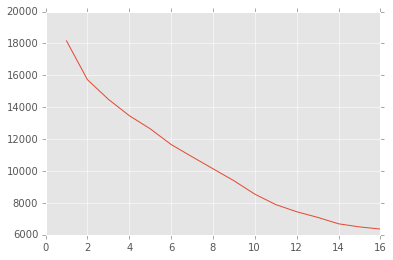

In [1587]:
# looking at inertia as we change k
inertia = []
k = []
for num in range(1,17):
    km = KMeans(n_clusters=num)
    km.fit(xts)
    k.append(num)
    inertia.append(km.inertia_)
plt.plot(k, inertia)
# clear elbow at around 12 or so

In [1588]:
km = KMeans(n_clusters=2)
km.fit(xts)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [1589]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = []
#for x in range(0,12):
#    collums= {scale.inverse_transform(km.cluster_centers_[x])}
#columns
#X_train.columns
#pd.DataFrame(columns, index=X_train.columns)    
columns = {x: scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,2)}
pd.DataFrame(columns, index=clusterData.columns)

,0,1
C(gender)[FEMALE],0.000,1.000
C(gender)[MALE],1.000,0.000
C(platform)[T.IOS],0.688,0.686
Average_Answer,10360.615,9684.235
Age,28.670,29.680
Amber,12.104,17.444
Bethany,3.290,5.085
Cynthia,26.671,27.009
David,9.633,8.592
Desiree,18.171,16.301


In [1590]:
clusterData['clusters']=km.labels_

In [1591]:
dataCleaned['clusters']= km.labels_

In [1592]:
clusterData.clusters.value_counts()

1    1102
0     109
dtype: int64

In [1593]:
# Lets see if we use clusters in our data frame to improve performance
trainC, testC = train_test_split(dataCleaned, test_size = 0.2)


In [1594]:
y_NOC, X_train_NOC = dmatrices('UserValsFac ~ 0 + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform)', 
                       trainC, return_type = 'dataframe')
X_train_NOC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 354 to 773
Data columns (total 15 columns):
C(gender)[FEMALE]     968 non-null float64
C(gender)[MALE]       968 non-null float64
C(platform)[T.IOS]    968 non-null float64
Average_Answer        968 non-null float64
Age                   968 non-null float64
Amber                 968 non-null float64
Bethany               968 non-null float64
Cynthia               968 non-null float64
David                 968 non-null float64
Desiree               968 non-null float64
Gina                  968 non-null float64
Kitty                 968 non-null float64
Laurie                968 non-null float64
Liz                   968 non-null float64
Samantha              968 non-null float64
dtypes: float64(15)
memory usage: 121.0 KB


In [1595]:
y, X_train = dmatrices('UserValsFac ~ 0 + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform) + C(clusters)', 
                       trainC, return_type = 'dataframe')
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 354 to 773
Data columns (total 16 columns):
C(gender)[FEMALE]     968 non-null float64
C(gender)[MALE]       968 non-null float64
C(platform)[T.IOS]    968 non-null float64
C(clusters)[T.1]      968 non-null float64
Average_Answer        968 non-null float64
Age                   968 non-null float64
Amber                 968 non-null float64
Bethany               968 non-null float64
Cynthia               968 non-null float64
David                 968 non-null float64
Desiree               968 non-null float64
Gina                  968 non-null float64
Kitty                 968 non-null float64
Laurie                968 non-null float64
Liz                   968 non-null float64
Samantha              968 non-null float64
dtypes: float64(16)
memory usage: 128.6 KB


In [1596]:
scale = StandardScaler()
y_NOC = np.ravel(y_NOC)
scale = StandardScaler()
y = np.ravel(y)

In [1597]:
X_test_NOC = dmatrix('0 + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform)', 
                       testC, return_type = 'dataframe')
X_test = dmatrix('0 + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform) + C(clusters)', 
                       testC, return_type = 'dataframe')

In [1599]:
svcNOC = SVC(kernel='rbf')
svcNOC.fit(X_train_NOC, y_NOC)
knnNOC = KNeighborsClassifier(n_neighbors=5)
knnNOC.fit(X_train_NOC, y_NOC)
dcNOC = DummyClassifier()
dcNOC.fit(X_train_NOC, y_NOC)
rfNOC = RandomForestClassifier(max_features='sqrt')
rfNOC.fit(X_train_NOC, y_NOC)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1600]:
#rf = RandomForestClassifier(max_features='sqrt')
#rf.fit(X_train, y)
# make our models
svc = SVC(kernel='rbf')
svc.fit(X_train, y)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y)
dc = DummyClassifier()
dc.fit(X_train, y)
rf = RandomForestClassifier(max_features='sqrt')
rf.fit(X_train, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1601]:
#predicted = rf.predict(X_test)
#print accuracy_score(testC['UserValsFac'],predicted)
# check our recall scores
print 'With Clusters: Benchmark classification performance is {}'.format(accuracy_score(testC['UserValsFac'],dc.predict(X_test)))
print 'Without Clusters: Benchmark classification performance is {}'.format(accuracy_score(testC['UserValsFac'],dcNOC.predict(X_test_NOC)))
print 'With Clusters: KNN classification performance is {}'.format(accuracy_score(testC['UserValsFac'],knn.predict(X_test)))
print 'Without Clusters: KNN classification performance is {}'.format(accuracy_score(testC['UserValsFac'],knnNOC.predict(X_test_NOC)))
print 'With Clusters: SVC classification performance is {}'.format(accuracy_score(testC['UserValsFac'],svc.predict(X_test)))
print 'Without Clusters: SVC classification performance is {}'.format(accuracy_score(testC['UserValsFac'],svcNOC.predict(X_test_NOC)))
print 'With Clusters: Random Forest classification performance is {}'.format(accuracy_score(testC['UserValsFac'],rf.predict(X_test)))
print 'Without Clusters: Random Forest classification performance is {}'.format(accuracy_score(testC['UserValsFac'],rfNOC.predict(X_test_NOC)))

With Clusters: Benchmark classification performance is 0.390946502058
Without Clusters: Benchmark classification performance is 0.366255144033
With Clusters: KNN classification performance is 0.423868312757
Without Clusters: KNN classification performance is 0.423868312757
With Clusters: SVC classification performance is 0.378600823045
Without Clusters: SVC classification performance is 0.378600823045
With Clusters: Random Forest classification performance is 0.609053497942
Without Clusters: Random Forest classification performance is 0.670781893004


In [1167]:
# Same as before with around 83% or so accuracy lets see what is important now
d = {'importance': rf.feature_importances_}
pd.DataFrame(d, index=X_train.columns).sort('importance')

,importance
C(gender)[MALE],0.005
C(gender)[FEMALE],0.008
C(clusters)[T.1],0.008
Liz,0.023
C(platform)[T.IOS],0.027
Samantha,0.029
Bethany,0.035
Laurie,0.042
Gina,0.047
Amber,0.057


In [1168]:
# So clustering does not help with predictions but lets instead now do logistic regression to see how accurately we can predict
# if a user will be a paying user or not!


In [1169]:
PayorFree=[]
for each in dataCleanedOld.UserValue:
    if (each == 'Low Value'):
        PayorFree.append(0)
    else: PayorFree.append(1)
dataCleanedOld['Paid'] = PayorFree


C:\Users\Vipul\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1170]:
train, test = train_test_split(dataCleanedOld, test_size = 0.2)


In [1171]:
#y, X = dmatrices('Paid ~ 0 + Age + C(platform) + C(gender) + Average_Answer + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha', train, return_type='dataframe')
y, X = dmatrices('Paid ~ Age + C(platform) + C(gender) + Average_Answer', train, return_type='dataframe')


In [1172]:
y = np.ravel(y)
dataCleanedOld.tail()

,UserKey,Average_Answer,UserValue,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,gender,platform,Age,UserValsFac,Paid
5772,OydmWiNDxzbBDm251UmQpEa9tBQG0cLk@talkpok.appsp...,1017,Low Value,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,IOS,32,4,0
5773,NMKUd2ZjRkk8C5FpI60oKTPuogaP1ghq@talkpok.appsp...,270,Low Value,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,MALE,IOS,18,4,0
5774,RJouF688FULJbrwQzuk0i2VZlzu8m5Vc@talkpok.appsp...,1877,Low Value,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100.000,FEMALE,ANDROID,44,4,0
5775,sZjalFGmfo6WHKxFcrqbAVPC3vCiuxWV@talkpok.appsp...,303,Low Value,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,IOS,27,4,0
5776,XPtvETDN8U3XawFAvI3h8SpzhXRqxJ25@talkpok.appsp...,627,Low Value,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,IOS,34,4,0


In [1173]:
scaler = StandardScaler(copy=True)
X_clean = scaler.fit(X).transform(X)

In [1174]:
# build our initial model
lr = LogisticRegression('l1')
lr.fit(X_clean, y)
dc = DummyClassifier()
dc.fit(X_clean, y)
svc = SVC(kernel='rbf')
svc.fit(X_clean, y)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_clean, y)
rf = RandomForestClassifier(max_features='sqrt')
rf.fit(X_clean, y)

print lr.coef_

[[ 0.          0.03177153 -0.07410683  0.37423903  0.05909501]]


In [1175]:
#X_train = dmatrix('Age + C(platform) + C(gender) + Average_Answer + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha', test, return_type='dataframe')
X_train = dmatrix('Age + C(platform) + C(gender) + Average_Answer', test, return_type='dataframe')

X_train = scaler.fit(X).transform(X_train)

In [1176]:
#predicted = lr.predict(X_train)
#print accuracy_score(predicted,test['Paid'])
print 'Benchmark classification performance is {}'.format(accuracy_score(test['Paid'],dc.predict(X_train)))
print 'Logistic Regression classification performance is {}'.format(accuracy_score(test['Paid'],lr.predict(X_train)))
print 'KNN classification performance is {}'.format(accuracy_score(test['Paid'],knn.predict(X_train)))
print 'SVC classification performance is {}'.format(accuracy_score(test['Paid'],svc.predict(X_train)))
print 'Random Forest classification performance is {}'.format(accuracy_score(test['Paid'],rf.predict(X_train)))

Benchmark classification performance is 0.655233069481
Logistic Regression classification performance is 0.774846086192
KNN classification performance is 0.749340369393
SVC classification performance is 0.775725593668
Random Forest classification performance is 0.730870712401


In [1177]:
# make a dataframe to view the coefficients of our model
d = {'Coefficients': lr.coef_[0], 'Features': X.columns}
pd.DataFrame(d, columns=['Coefficients', 'Features'])

,Coefficients,Features
0,0.000,Intercept
1,0.032,C(platform)[T.IOS]
2,-0.074,C(gender)[T.MALE]
3,0.374,Age
4,0.059,Average_Answer


In [1178]:
d = {'Coefficients': np.exp(lr.coef_[0]), 'Features': X.columns}
pd.DataFrame(d, columns=['Coefficients', 'Features'])

,Coefficients,Features
0,1.000,Intercept
1,1.032,C(platform)[T.IOS]
2,0.929,C(gender)[T.MALE]
3,1.454,Age
4,1.061,Average_Answer


In [1179]:
# Lets do PCA to visualize this
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(n_components=2)
pca.fit(X_clean)
pca.explained_variance_ratio_

array([ 0.2759494 ,  0.25238745])

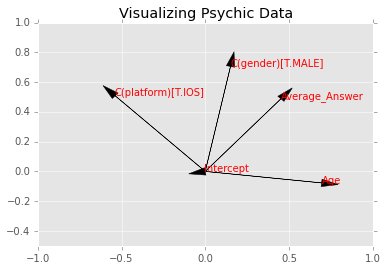

In [1180]:
comp = pca.components_

plt.style.use('ggplot')
plt.title('Visualizing Psychic Data')
plt.xlim(-1.0,1.0)
plt.ylim(-0.5, 1.0)
for index, feature in enumerate(X.columns):
    plt.arrow(0, 0, comp[0][index], comp[1][index], feature, color='red',
             fc="k", ec="k",head_width=0.05, head_length=0.1)
for index, feature in enumerate(X.columns):
    plt.text(comp[0][index], comp[1][index], feature, color='red')

In [1045]:
# Lets add a feature where we take the top psychic of each user and use them to figure out if we can figure out who will pay or not

favPsychic = []
for Amber, Bethany, Cynthia, David, Desiree, Gina, Kitty, Laurie, Liz, Samantha in zip(dataCleanedOld.Amber, dataCleanedOld.Bethany, dataCleanedOld.Cynthia, dataCleanedOld.David, dataCleanedOld.Desiree, dataCleanedOld.Gina, dataCleanedOld.Kitty, dataCleanedOld.Laurie, dataCleanedOld.Liz, dataCleanedOld.Samantha):
    theMax = max(Amber, Bethany, Cynthia, David, Desiree, Gina, Kitty, Laurie, Liz, Samantha)
    if Amber == theMax: 
        favPsychic.append('Amber')
    elif Bethany == theMax: favPsychic.append('Bethany')
    elif Cynthia == theMax: favPsychic.append('Cynthia')
    elif David == theMax: favPsychic.append('David')
    elif Desiree == theMax: favPsychic.append('Desiree')
    elif Gina == theMax: favPsychic.append('Gina')
    elif Kitty == theMax: favPsychic.append('Kitty')
    elif Laurie == theMax: favPsychic.append('Laurie')
    elif Liz == theMax: favPsychic.append('Liz')
    elif Samantha == theMax: favPsychic.append('Samantha')
    
dataCleanedOld['favPsychic'] = favPsychic 

C:\Users\Vipul\Anaconda\lib\site-packages\IPython\kernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1046]:
train, test = train_test_split(dataCleanedOld, test_size = 0.2)
y, X = dmatrices('Paid ~ 0 + Age + C(platform) + C(gender) + Average_Answer + C(favPsychic)', train, return_type='dataframe')
y = np.ravel(y)
scaler = StandardScaler(copy=True)
X_clean = scaler.fit(X).transform(X)

In [1048]:
lr = LogisticRegression('l1')
lr.fit(X_clean, y)
dc = DummyClassifier()
dc.fit(X_clean, y)
svc = SVC(kernel='rbf')
svc.fit(X_clean, y)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_clean, y)
rf = RandomForestClassifier(max_features='sqrt')
rf.fit(X_clean, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1049]:
X_train = dmatrix('Age + C(platform) + C(gender) + Average_Answer + C(favPsychic)', test, return_type='dataframe')

X_train = scaler.fit(X).transform(X_train)

In [1050]:
print 'Benchmark classification performance is {}'.format(accuracy_score(test['Paid'],dc.predict(X_train)))
print 'Logistic Regression classification performance is {}'.format(accuracy_score(test['Paid'],lr.predict(X_train)))
print 'KNN classification performance is {}'.format(accuracy_score(test['Paid'],knn.predict(X_train)))
print 'SVC classification performance is {}'.format(accuracy_score(test['Paid'],svc.predict(X_train)))
print 'Random Forest classification performance is {}'.format(accuracy_score(test['Paid'],rf.predict(X_train)))

Benchmark classification performance is 0.639401934916
Logistic Regression classification performance is 0.774846086192
KNN classification performance is 0.737906772208
SVC classification performance is 0.773966578716
Random Forest classification performance is 0.744063324538


In [1051]:
d = {'Coefficients': np.exp(lr.coef_[0]), 'Features': X.columns}
pd.DataFrame(d, columns=['Coefficients', 'Features'])

,Coefficients,Features
0,0.992,C(platform)[ANDROID]
1,1.028,C(platform)[IOS]
2,0.916,C(gender)[T.MALE]
3,1.124,C(favPsychic)[T.Bethany]
4,0.992,C(favPsychic)[T.Cynthia]
5,1.170,C(favPsychic)[T.David]
6,1.098,C(favPsychic)[T.Desiree]
7,1.049,C(favPsychic)[T.Gina]
8,0.963,C(favPsychic)[T.Kitty]
9,0.947,C(favPsychic)[T.Laurie]


In [1054]:
# Lets do PCA to visualize this
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(n_components=2)
pca.fit(X_clean)

RandomizedPCA(copy=True, iterated_power=3, n_components=2, random_state=None,
       whiten=False)

In [1055]:
pca.explained_variance_ratio_

array([ 0.15040263,  0.0964347 ])

In [1056]:
comp = pca.components_

In [1059]:
X_train

array([[ 1.47666714, -1.47666714, -0.34082127, ..., -0.20598833,
        -0.94904875,  0.74133121],
       [ 1.47666714,  0.67720069, -0.34082127, ..., -0.20598833,
        -0.01581063, -0.5800082 ],
       [ 1.47666714,  0.67720069,  2.93408921, ..., -0.20598833,
        -0.59908446, -0.64744512],
       ..., 
       [ 1.47666714,  0.67720069, -0.34082127, ..., -0.20598833,
         0.45080842, -0.72989629],
       [ 1.47666714, -1.47666714, -0.34082127, ..., -0.20598833,
        -0.36577493, -0.19370919],
       [ 1.47666714,  0.67720069, -0.34082127, ..., -0.20598833,
         0.21749889, -0.73617344]])

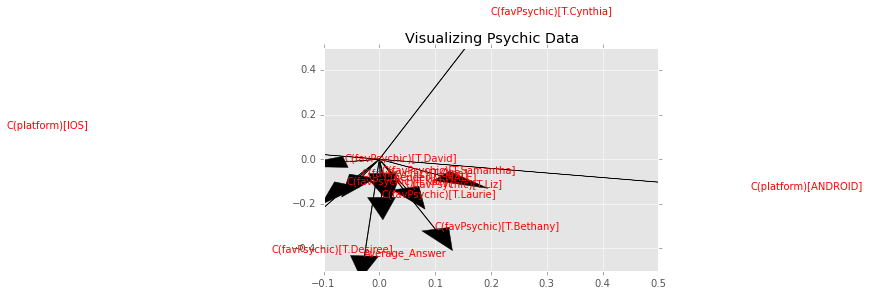

In [1062]:
plt.style.use('ggplot')
plt.title('Visualizing Psychic Data')
plt.xlim(-0.1,.5)
plt.ylim(-0.5, 0.5)
for index, feature in enumerate(X.columns):
    plt.arrow(0, 0, comp[0][index], comp[1][index], feature, color='red',
             fc="k", ec="k",head_width=0.05, head_length=0.1)
for index, feature in enumerate(X.columns):
    plt.text(comp[0][index], comp[1][index], feature, color='red')